In [1]:

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
%matplotlib inline

In [2]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [3]:
def plot_transportation_mod(transportation_mode, df):
    data = df[df['activity'] == transportation_mode][['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']][:8000]
    
    axis = data.plot(subplots = True, figsize =(20, 20), title = transportation_mode)
    
    for ax in axis:
        ax.legend(loc = 'lower left', bbox_to_anchor=(1.0,0.5))


In [4]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['fAX'] = gaussian_filter(df['AX'], window_length)
    df1['fAY'] = gaussian_filter(df['AY'], window_length)
    df1['fAZ'] = gaussian_filter(df['AZ'], window_length)

    df1['fGX'] = gaussian_filter(df['GX'], window_length)
    df1['fGY'] = gaussian_filter(df['GY'], window_length)
    df1['fGZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1

In [206]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [5]:
#data for bike
acc_file = 'data/Bike2308/2018-08-23_16-18-07/AccelerometerLinear.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-18-07/Gyroscope.csv'

df_bike = read_csv_file(acc_file, gyro_file, 'bike')
df_bike.reset_index(drop = True, inplace = True)
print("shape -", df_bike.shape)
df_bike = df_bike[3000:13000]
df_bike.reset_index(drop = True, inplace = True)
print("shape -", df_bike.shape)
df_bike.head()

shape - (14413, 8)
shape - (10000, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
0,60002,0.946191,0.335965,-1.380772,-0.063095,-0.078720,0.035873,bike
1,60021,0.282677,0.677211,-0.592512,-0.114227,-0.141571,0.008179,bike
2,60041,0.541477,0.866996,1.060262,-0.052444,-0.141571,-0.037628,bike
3,60061,0.069439,0.456029,0.068076,0.149963,0.006500,-0.031235,bike
4,60082,0.005020,-0.462948,-1.091515,0.076462,-0.005219,-0.020584,bike


In [6]:
#data for car

acc_file = 'data/car/2018-08-17_16-43-04/AccelerometerLinear.csv'
gyro_file= 'data/car/2018-08-17_16-43-04/Gyroscope.csv'

df_car = read_csv_file(acc_file, gyro_file, 'car')

print("shape -", df_car.shape)
df_car = df_car[1300:12000]
df_car.reset_index(drop = True, inplace = True)
print("shape -", df_car.shape)
df_car.head()

shape - (6646, 8)
shape - (5346, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
0,26000,1.310577,-0.599656,-2.653413,-0.030792,-0.118576,-0.002655,car
1,26020,0.001736,-1.469157,2.047003,-0.094711,0.188217,0.012268,car
2,26041,-0.361463,-0.839294,0.419466,0.088516,0.030563,0.010132,car
3,26061,1.720914,-0.621697,0.038787,-0.090454,-0.015244,-0.003723,car
4,26080,2.569507,-1.287929,-0.327906,-0.049973,-0.208054,-0.003723,car


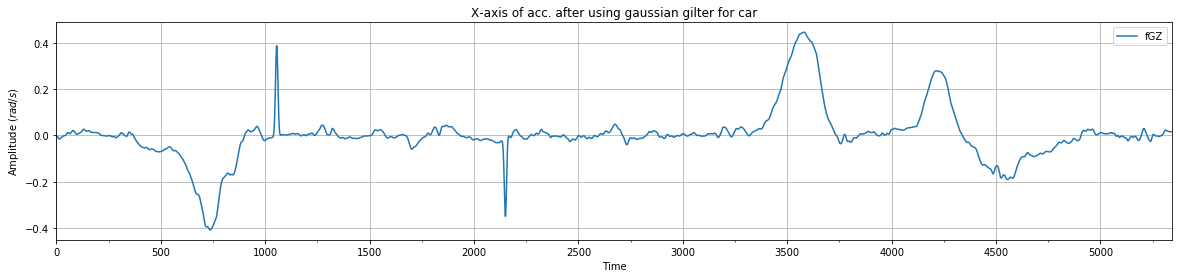

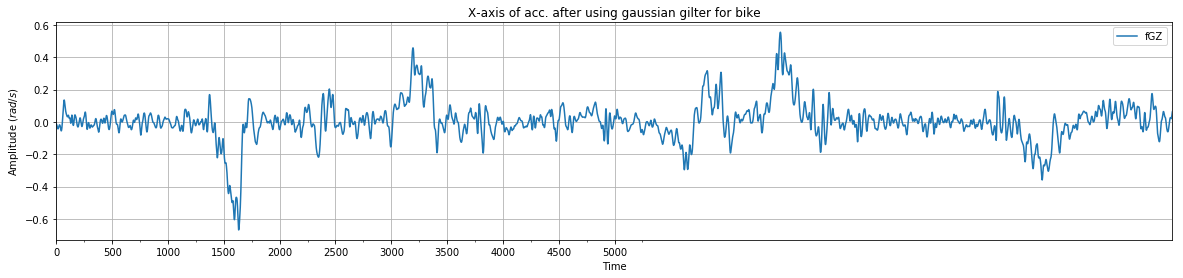

In [120]:
df_car_smooth = GaussianFilter(df_car, 5)
df_car_smooth['fAccMean'] = (df_car_smooth['fAX'] + df_car_smooth['fAY'] + df_car_smooth['fAZ'])/3
df_car_smooth['fGyroMean'] = (df_car_smooth['fGX'] + df_car_smooth['fGY'] + df_car_smooth['fGZ'])/3
fig, ax = plt.subplots()
n = len(df_car_smooth)

df_car_smooth[['fGZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for car", ax=ax)
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)



fig, ax = plt.subplots()
n = len(df_bike_smooth)
df_bike_smooth = GaussianFilter(df_bike, 5)
df_bike_smooth['fAccMean'] = (df_bike_smooth['fAX'] + df_bike_smooth['fAY'] + df_bike_smooth['fAZ'])/3
df_bike_smooth['fGyroMean'] = (df_bike_smooth['fGX'] + df_bike_smooth['fGY'] + df_bike_smooth['fGZ'])/3
df_bike_smooth[['fGZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for bike",ax=ax)
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')

# plt.axis([0, 10000, -1.0, 1.0])
major_tick = np.arange(0, n, 500)
minor_tick = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor = True)
plt.grid(True)
# ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# # Customize the minor grid
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')



In [127]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 30
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gz = df['fGZ'].values[i: i + N_TIME_STEPS]
        gy = df['fGY'].values[i: i + N_TIME_STEPS]
        
#         xx = pd.Series(gz)
#         xx.plot()
    #     label = stats.mode(df['acdist_fun = manhattan_distances
loss= []
for i in range(len(car_segments)):
    x = car_segments[i][0]
    y = car_segments[134][0]
#     xx = pd.Series(x)
#     xx.plot()
    dist, cost, acc, path = dtw(x, y, dist_fun)
    loss.append(dist)
    print(i,"=>",dist)tivity'][i: i + N_TIME_STEPS])[0][0]
    
        label = "ST"
        segments.append([gz,gy])
        labels.append(label)
    return segments, labels

In [155]:
car_segments, car_labels = segmentation(df_car_smooth, 400)
np.array(car_segments).shape


(165, 2, 400)

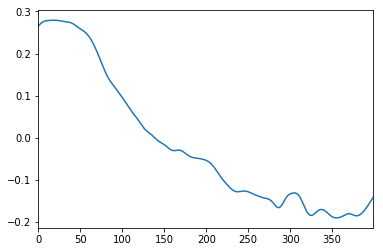

In [249]:
x = car_segments[140][0]
xx = pd.Series(x)
xx.plot()

In [250]:
car_labels[10:23] = ["RT"] * (23-10)
car_labels[141:153] = ["RT"] * (5)
car_labels[104:118] = ["LT"] * (5)
car_labels[128:141] = ["LT"] * (5)


In [251]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [252]:
car_colors = pltcolor(car_labels)


In [166]:
def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path

In [167]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [219]:
def loss_for_segments(segments, comp, dist_fun):
    loss =[]
    length = len(segments)
    for i in range(length):
        x = segments[i][0]
        dist, cost, acc, path = dtw(x, y, dist_fun)
        print(i , '=>', dist)
        loss.append(dist)
        
    return loss
    

In [213]:
dist_fun = manhattan_distances
y = car_segments[17][0]
diff_wrt_RT = loss_for_segments(car_segments, y ,dist_fun)

0 => 0.0870582123655
1 => 0.0907073212466
2 => 0.0863243343123
3 => 0.0809051180515
4 => 0.0780887346261
5 => 0.0750512967262
6 => 0.0731986961559
7 => 0.0611394235171
8 => 0.0457637095802
9 => 0.041436154747
10 => 0.04073727879
11 => 0.0430164276075
12 => 0.0434386260007
13 => 0.015368843045
14 => 0.0084254660383
15 => 0.00814455774583
16 => 0.0014460341148
17 => 0.0
18 => 0.000539966271121
19 => 0.00150535295262
20 => 0.00510398854147
21 => 0.0138161099622
22 => 0.0322214505835
23 => 0.0450700829327
24 => 0.0604338376268
25 => 0.0547760075689
26 => 0.0503514323744
27 => 0.0496206084459
28 => 0.0505687114689
29 => 0.0650169437276
30 => 0.0919985866221
31 => 0.0909580213657
32 => 0.089620150946
33 => 0.0890534414217
34 => 0.0948769646471
35 => 0.098077192831
36 => 0.0917434618453
37 => 0.0911222499844
38 => 0.0905378752437
39 => 0.0901405041802
40 => 0.0902545964937
41 => 0.0901933083645
42 => 0.0894049456478
43 => 0.0878526742698
44 => 0.0862177143268
45 => 0.0828909033669
46 => 0.081

In [217]:
diff_wrt_RT

In [214]:
dist_fun = manhattan_distances
y = car_segments[134][0]
diff_wrt_LT = loss_for_segments(car_segments, y ,dist_fun)

0 => 0.0438773539237
1 => 0.0422019391249
2 => 0.0414088562152
3 => 0.0409747094486
4 => 0.0405906233082
5 => 0.0429024825892
6 => 0.0460102998147
7 => 0.0470681748862
8 => 0.0481754497264
9 => 0.0518759589841
10 => 0.0578200688846
11 => 0.0681047806878
12 => 0.082410470042
13 => 0.10601590556
14 => 0.117646031784
15 => 0.120137126822
16 => 0.121005292692
17 => 0.123289116315
18 => 0.127250148636
19 => 0.138540623334
20 => 0.129329032002
21 => 0.124292421401
22 => 0.122695255954
23 => 0.0790003577641
24 => 0.0651936654569
25 => 0.0495071652279
26 => 0.0353373148801
27 => 0.0270577821162
28 => 0.0201828367995
29 => 0.0146309394527
30 => 0.0133597769108
31 => 0.0133774150626
32 => 0.0119547675199
33 => 0.0112226084948
34 => 0.00990914178164
35 => 0.0401490680554
36 => 0.0419921231944
37 => 0.0416953222441
38 => 0.0421986723102
39 => 0.0427252419411
40 => 0.0417220276451
41 => 0.0412565668174
42 => 0.0411379987762
43 => 0.043626784459
44 => 0.0419386860718
45 => 0.0481947187652
46 => 0.04

In [215]:
dist_fun = manhattan_distances
y = car_segments[2][0]
diff_wrt_ST = loss_for_segments(car_segments, y ,dist_fun)

0 => 0.00180234770695
1 => 0.000394756724086
2 => 0.0
3 => 0.000448860860316
4 => 0.000867797613301
5 => 0.00131281979005
6 => 0.00163162618578
7 => 0.00408263242314
8 => 0.00698973191336
9 => 0.0122992476963
10 => 0.019769819512
11 => 0.0321046449653
12 => 0.045406626108
13 => 0.0677136900494
14 => 0.080204148757
15 => 0.0839843447457
16 => 0.0854244614303
17 => 0.0863243343123
18 => 0.0889034405691
19 => 0.0943090477313
20 => 0.0879550524913
21 => 0.0841446936473
22 => 0.0837015079725
23 => 0.0760449278323
24 => 0.0628918173552
25 => 0.0478588989564
26 => 0.0341327569552
27 => 0.0265068060214
28 => 0.020229507953
29 => 0.0152419318414
30 => 0.014047149794
31 => 0.0145128190095
32 => 0.0134272816759
33 => 0.0130457482962
34 => 0.0122878520694
35 => 0.0111413579582
36 => 0.00633386508514
37 => 0.00659849971068
38 => 0.00769066048943
39 => 0.00845532805454
40 => 0.00566927313493
41 => 0.00572245825048
42 => 0.00623308591334
43 => 0.00377717424935
44 => 0.00243309131355
45 => 0.004893500

In [253]:
los = pd.read_csv('data/losses.csv', index_col=False)


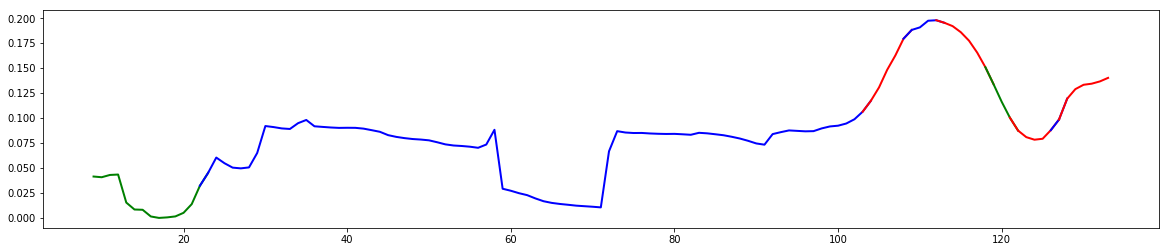

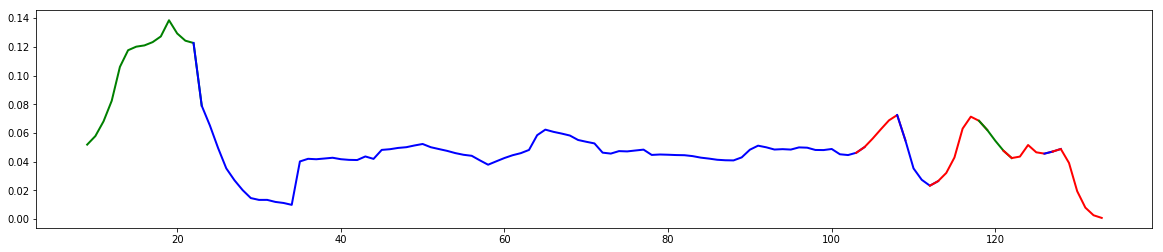

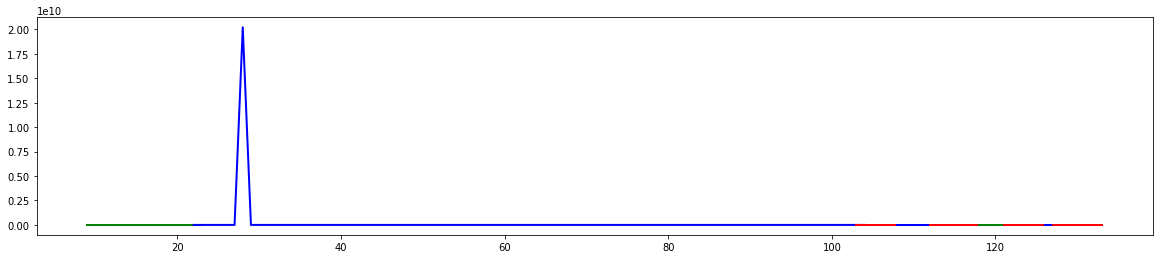

In [256]:
y = los['RT']
x = np.arange(len(y))
plot_multicolored_lines(x,y,car_colors)
plt.show()
y = los['LT']
x = np.arange(len(y))
plot_multicolored_lines(x,y,car_colors)
plt.show()
y = los['ST']
x = np.arange(len(y))
plot_multicolored_lines(x,y,car_colors)
plt.show()

Text(0,0.5,'Amplitude ($rad/s$)')

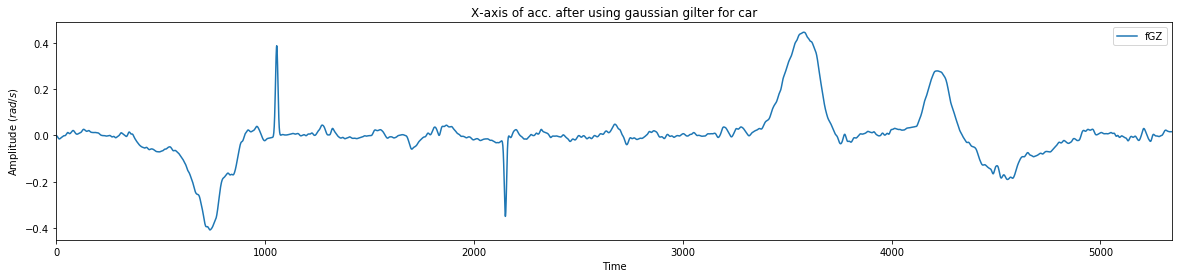

In [170]:
df_car_smooth[['fGZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian filter for car")
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')


Text(0,0.5,'Difference/Loss')

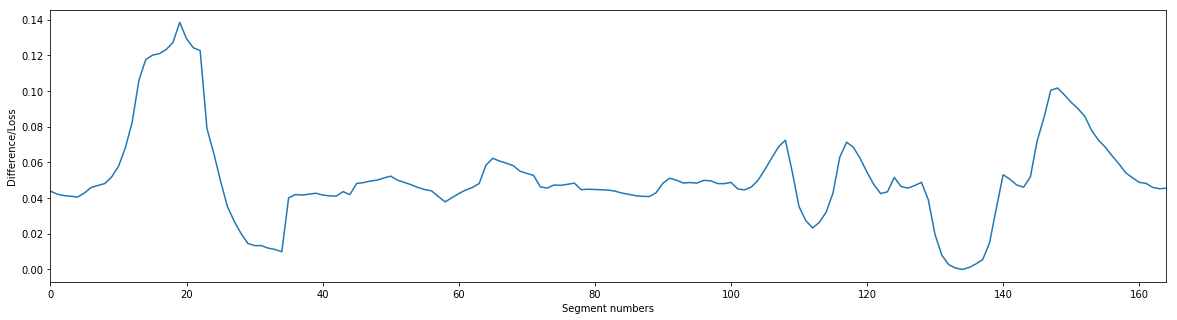

In [171]:
loss_series = pd.Series(loss)
loss_series.plot(figsize=(20,5))
plt.xlabel('Segment numbers')
plt.ylabel('Difference/Loss')

Text(0,0.5,'Difference/Loss')

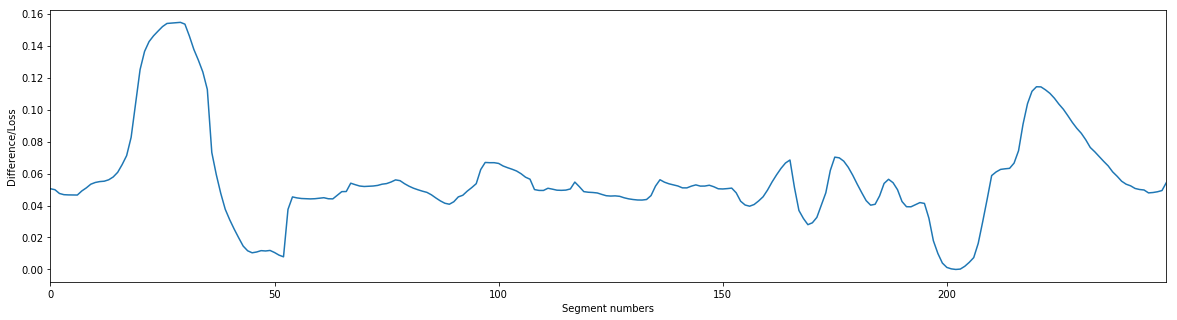

In [147]:
loss_series = pd.Series(loss)
loss_series.plot(figsize=(20,5))
plt.xlabel('Segment numbers')
plt.ylabel('Difference/Loss')

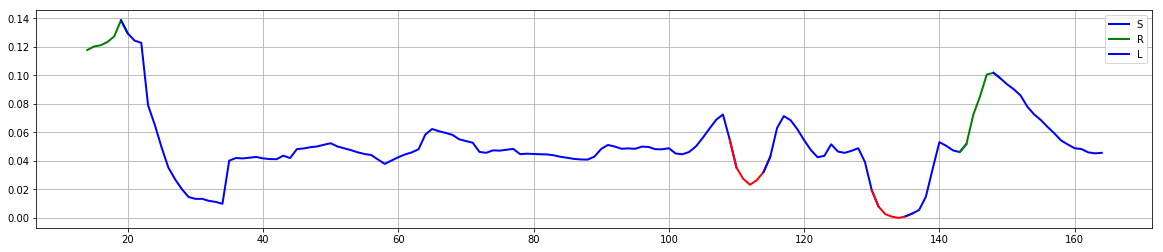

In [151]:
print(len(df_bike_smooth))
bike_segments, bike_labels = segmentation(df_bike_smooth, 500)
np.array(bike_segments).shape

10000


(317, 2, 500)

In [152]:
colors = pltcolor(bike_labels)
colors

['blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 

10000


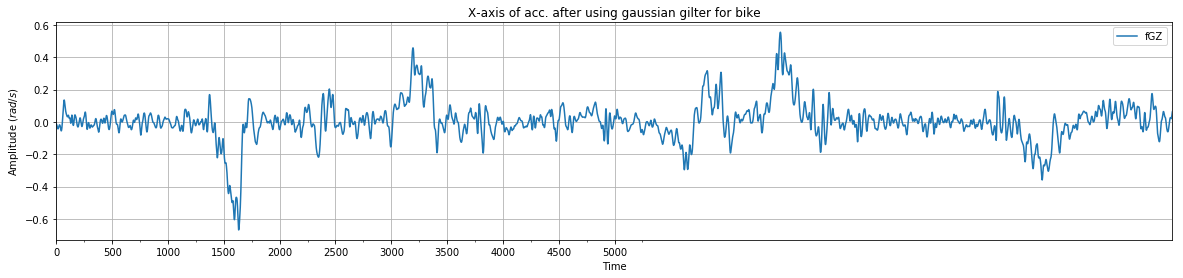

In [144]:
fig, ax = plt.subplots()
n = len(df_bike_smooth)
print(n)
major_tick = np.arange(0, n*2, 500)
minor_tick = np.arange(0, n*2, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor = True)
df_bike_smooth['fAccMean'] = (df_bike_smooth['fAX'] + df_bike_smooth['fAY'] + df_bike_smooth['fAZ'])/3
df_bike_smooth['fGyroMean'] = (df_bike_smooth['fGX'] + df_bike_smooth['fGY'] + df_bike_smooth['fGZ'])/3
df_bike_smooth[['fGZ']].plot(figsize = (20,4), ax = ax, title = "X-axis of acc. after using gaussian filter for bike")
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')
plt.grid(True)


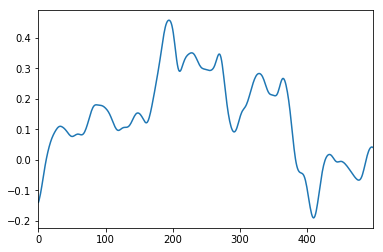

In [129]:
x = bike_segments[150][0]
xx = pd.Series(x)
xx.plot()

In [130]:
dist_fun = manhattan_distances
loss= []
for i in range(len(bike_segments)):
    x = bike_segments[i][0]
    y = bike_segments[202][0]
#     xx = pd.Series(x)
#     xx.plot()
    dist, cost, acc, path = dtw(x, y, dist_fun)
    loss.append(dist)
    print(i,"=>",dist)

0 => 0.00957772980457
1 => 0.00939706420376
2 => 0.00996508069269
3 => 0.0163119232635
4 => 0.0108748750399
5 => 0.0095670495046
6 => 0.00771677954921
7 => 0.00766479927387
8 => 0.00888419764195
9 => 0.00908581464589
10 => 0.00984804844876
11 => 0.00863012971687
12 => 0.00925724617592
13 => 0.00950788355659
14 => 0.00705849065229
15 => 0.00618399198306
16 => 0.00836926614701
17 => 0.00683840646815
18 => 0.00592144031666
19 => 0.00697126331831
20 => 0.0109450887516
21 => 0.00957592812412
22 => 0.00988249552646
23 => 0.00959344055883
24 => 0.00989354181819
25 => 0.0103999462429
26 => 0.00873267047477
27 => 0.00821622903989
28 => 0.00901887290447
29 => 0.0104902040196
30 => 0.01023750109
31 => 0.0103293547951
32 => 0.0102547172029
33 => 0.00632772698209
34 => 0.00760746606918
35 => 0.00921650907903
36 => 0.0103107996386
37 => 0.00737344074266
38 => 0.00770962337496
39 => 0.00781643986155
40 => 0.00657500329876
41 => 0.00841803144589
42 => 0.00959007651614
43 => 0.00914176471045
44 => 0.00

360 => 0.00737561636443
361 => 0.00819134031718
362 => 0.00813432107878
363 => 0.00701262999365
364 => 0.0114973411454
365 => 0.0104742411272
366 => 0.00802048068826
367 => 0.00701990333426
368 => 0.00659848157106
369 => 0.0109099605742
370 => 0.00906629797622
371 => 0.00847429631876
372 => 0.00963916711426
373 => 0.00919381355689
374 => 0.01096754498
375 => 0.0101880811071
376 => 0.0104022494859
377 => 0.00933922603896
378 => 0.0109667262436
379 => 0.0100067371025
380 => 0.0104042619776
381 => 0.00995485530234
382 => 0.0147024219922
383 => 0.0128685514556
384 => 0.0124924862548
385 => 0.0106682409768
386 => 0.0101350698876
387 => 0.00976703085016
388 => 0.00927229279579
389 => 0.00844645636918
390 => 0.0091495609417
391 => 0.00929416551791
392 => 0.00911101642044
393 => 0.00835468472108
394 => 0.0094133386513
395 => 0.0118702227103
396 => 0.0119203483944
397 => 0.00784133052007
398 => 0.00931415781274
399 => 0.0118333003116
400 => 0.00868788798038
401 => 0.0143597831008
402 => 0.01499

Text(0,0.5,'Amplitude ($rad/s$)')

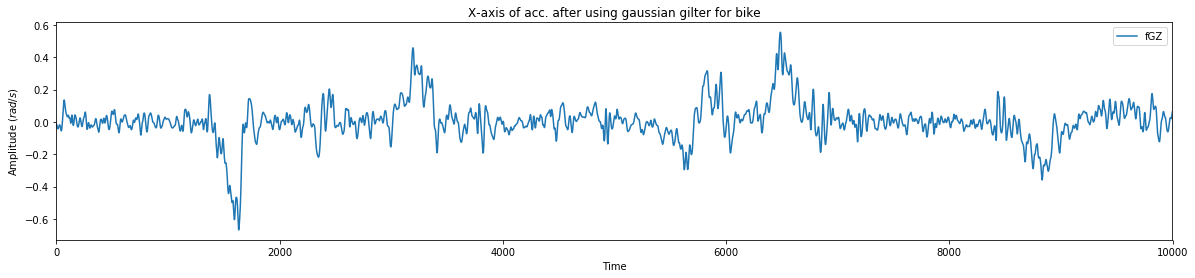

In [135]:
df_bike_smooth['fAccMean'] = (df_bike_smooth['fAX'] + df_bike_smooth['fAY'] + df_bike_smooth['fAZ'])/3
df_bike_smooth['fGyroMean'] = (df_bike_smooth['fGX'] + df_bike_smooth['fGY'] + df_bike_smooth['fGZ'])/3
df_bike_smooth[['fGZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for bike")
plt.xlabel('Time')
plt.ylabel('Amplitude ($rad/s$)')

Text(0,0.5,'Difference/Loss')

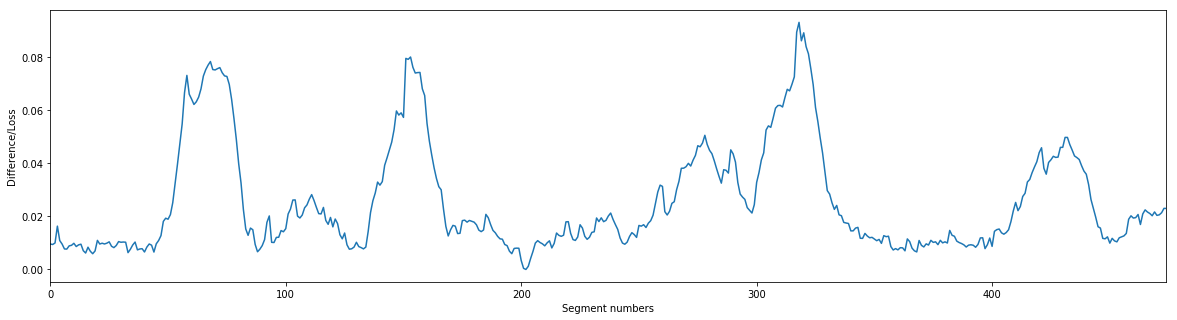

In [134]:

loss_series = pd.Series(loss)
loss_series.plot(figsize=(20,5))
plt.xlabel('Segment numbers')
plt.ylabel('Difference/Loss')

In [ ]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green',nan:'black'}
    for l in lst:
        cols.append(colors[l])
        
    return cols
#Create the colors list using the function above
cols=pltcolor(ground_truth)